In [5]:
#import everything
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
import math
import time
import keyboard
import matplotlib.pyplot as plt
import pandas as pd
from transformers import AdamW
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification
import spacy
import pydantic
import requests
from bs4 import BeautifulSoup
from lumibot.brokers import Alpaca
from alpaca_trade_api import REST
from datetime import datetime, timedelta 
import time as Time
import pandas as pd
import scipy.stats as stats
import dask.dataframe as dd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from copy import deepcopy

G:\Python\Lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [7]:
Symbols = [
    'AAPL',
    'MSFT',
    'AMZN',
    'TSLA',
    'GOOGL',
    'META',
    'NVDA',
    'NFLX'
]
for symbol in Symbols:
    # Get news data and fix it
    news_symbol = pd.read_csv(f"../../../Data/Sentiment_anal_news_data/news_data_for_{symbol}")
    news_symbol.drop(columns=['Unnamed: 0'], inplace=True)
    news_symbol['date'] = pd.to_datetime(news_symbol['date'])
    news_symbol = news_symbol[news_symbol['date'].dt.year != 2015]
    news_symbol = news_symbol[news_symbol['date'].dt.year != 2014]
    news_symbol.set_index('date', inplace=True)
    news_symbol.sort_index(inplace=True)
    news_symbol = news_symbol.groupby(news_symbol.index).agg({'text': ' '.join})
    # Get market data and fix it
    market_symbol = pd.read_csv(f"../../../Data/Sentiment_anal_market_data/market_data_for_{symbol}")
    market_symbol.drop(columns=['Unnamed: 0'], inplace=True)
    market_symbol['timestamp'] = pd.to_datetime(market_symbol['timestamp'])
    market_symbol['date'] = market_symbol['timestamp'].dt.date
    market_symbol = market_symbol.drop(columns=['timestamp'])
    market_symbol['date'] = pd.to_datetime(market_symbol['date'])
    market_symbol.set_index('date', inplace=True)
    market_symbol.sort_index(inplace=True)
    # Join market and news data
    market_symbol_s = market_symbol.copy()
    market_symbol_s['text'] = ""

    date_range = pd.date_range(start=market_symbol.index.min(), end=market_symbol.index.max())
    previous_date = None
    buffer = ""
    for date in date_range:
    
        if date not in news_symbol.index:
            continue
    
        buffer = buffer + news_symbol.at[date, 'text'] + " "
        
        if date in market_symbol_s.index:
            market_symbol_s.at[date, 'text'] = buffer
            buffer = ""
    
    combined_data = market_symbol_s.drop(['high','low','trade_count','open','volume','vwap'], axis=1)
    print(combined_data)








             close                                               text
date                                                                 
2016-01-04  105.35  FBR: Apple Growth Fears 'Overblown'.  This Div...
2016-01-05  102.71  Multiple Sources Report Apple's iPhone 7 Will ...
2016-01-06  100.70  Apple, Fitbit Weakness Drive Down Suppliers.  ...
2016-01-07   96.45  AAPL.. Report: Apple Acquired An Artificial In...
2016-01-08   96.96  Report: iPhone 6s And 6S Plus Supply Chain Rel...
...            ...                                                ...
2023-12-22  193.60  'Apple Explores AI Deals With News Publishers;...
2023-12-26  193.05  Benzinga Bulls And Bear: Apple, Tesla, Ethereu...
2023-12-27  193.15  Market Clubhouse Morning Memo - December 27th,...
2023-12-28  193.58  Joe Biden Vs. Apple Watch: White House Upholds...
2023-12-29  192.53  Your Next Mac Could Be A Gaming Powerhouse As ...

[1821 rows x 2 columns]
             close                                               

In [ ]:
Symbols = [
    'AAPL',
    'MSFT',
    'AMZN',
    'TSLA',
    'GOOGL',
    'META',
    'NVDA',
    'NFLX'
]
combined_data = pd.DataFrame()
for symbol in Symbols:
    # Get news data and fix it
    news_symbol = pd.read_csv(f"../../../Data/Sentiment_anal_news_data/news_data_for_{symbol}")
    news_symbol.drop(columns=['Unnamed: 0'], inplace=True)
    news_symbol['date'] = pd.to_datetime(news_symbol['date'])
    news_symbol = news_symbol[news_symbol['date'].dt.year != 2015]
    news_symbol = news_symbol[news_symbol['date'].dt.year != 2014]
    news_symbol.set_index('date', inplace=True)
    news_symbol.sort_index(inplace=True)
    news_symbol = news_symbol.groupby(news_symbol.index).agg({'text': ' '.join})
    # Get market data and fix it
    market_symbol = pd.read_csv(f"../../../Data/Sentiment_anal_market_data/market_data_for_{symbol}")
    market_symbol.drop(columns=['Unnamed: 0'], inplace=True)
    market_symbol['timestamp'] = pd.to_datetime(market_symbol['timestamp'])
    market_symbol['date'] = market_symbol['timestamp'].dt.date
    market_symbol = market_symbol.drop(columns=['timestamp'])
    market_symbol['date'] = pd.to_datetime(market_symbol['date'])
    market_symbol.set_index('date', inplace=True)
    market_symbol.sort_index(inplace=True)
    # Join market and news data
    market_symbol_s = market_symbol.copy()
    market_symbol_s['text'] = ""

    date_range = pd.date_range(start=market_symbol.index.min(), end=market_symbol.index.max())
    previous_date = None
    buffer = ""
    reset_buffer = False
    for date in date_range:
    
        if date not in news_symbol.index:
            if date in market_symbol_s.index:
                market_symbol_s.at[date, 'text'] = buffer
            continue

        if reset_buffer:
            buffer = ""
            reset_buffer = False
        
        buffer = buffer + news_symbol.at[date, 'text'] + " "
        
        if date in market_symbol_s.index:
            market_symbol_s.at[date, 'text'] = buffer
            reset_buffer = True
    
    combined_data_symbol = market_symbol_s.drop(['high','low','trade_count','open','volume','vwap'], axis=1)
    combined_data_symbol = combined_data_symbol[combined_data_symbol['text'] != ""]
    combined_data_symbol['short_term_return'] = combined_data_symbol['close'].pct_change(periods=1).shift(-1) * 100
    combined_data_symbol.dropna(inplace=True)

    # Define the number of bins
    num_bins = 100
    
    # Calculate min and max values for short-term and long-term returns
    min_short_term = combined_data_symbol['short_term_return'].min()
    max_short_term = combined_data_symbol['short_term_return'].max()
    
    # Generate bin edges using numpy.linspace
    bins_short_term = np.linspace(min_short_term, max_short_term, num_bins + 1)
    
    # Calculate statistics
    mean_short_term = combined_data_symbol['short_term_return'].mean()
    std_short_term = combined_data_symbol['short_term_return'].std()
    
    # Percentile values
    percentiles = [60, 70, 80, 90] 
    z_scores = [stats.norm.ppf(p / 100) for p in percentiles] 
    z_scores = np.array(z_scores)
    z_scores_reversed = z_scores[::-1]
    z_scores_reversed_inverted = -z_scores_reversed
    z_scores = np.concatenate((z_scores_reversed_inverted, z_scores))
    print(z_scores)
    
    # Calculate thresholds based on these z-scores
    thresholds_short_term = [mean_short_term + z * std_short_term for z in z_scores]
    
    # Plotting histograms
    plt.figure(figsize=(12, 6))
    
    # Plot histogram for short-term returns
    plt.subplot(2, 1, 1)
    plt.hist(combined_data_symbol['short_term_return'], bins=bins_short_term, color='b', edgecolor='black', alpha=0.7)
    plt.axvline(mean_short_term, color='k', linestyle='dashed', linewidth=1, label='Mean')
    
    # Plot z-score thresholds
    for z, threshold in zip(z_scores, thresholds_short_term):
        plt.axvline(threshold, color='g', linestyle='dashed', linewidth=1, label=f'Z-score: {z:.2f}')
        
    plt.title('Short Term Return Distribution')
    plt.xlabel('Percent Change')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

    combined_data_symbol['label_short'] = 0
    for i in range(len(percentiles)-1, -1, -1):
        tresh = thresholds_short_term[i]
        #print(f"{i-len(percentiles)} to smaller then {i}")
        combined_data_symbol.loc[combined_data_symbol['short_term_return'] < tresh, 'label_short'] = i-len(percentiles)
    print("-----")
    for i in range(len(percentiles), len(thresholds_short_term)):
        tresh = thresholds_short_term[i]
        #print(f"{i - len(percentiles) + 1} to bigger then {i}")
        combined_data_symbol.loc[combined_data_symbol['short_term_return'] > tresh, 'label_short'] = i - len(percentiles) + 1
        
    combined_data = pd.concat([combined_data, combined_data_symbol])

combined_data








In [ ]:
# Count the occurrences of each label in 'label_short'
label_short_counts = combined_data['label_short'].value_counts()

# Count the occurrences of each label in 'label_long'
#label_long_counts = combined_data['label_long'].value_counts()

# Print the results
print("Counts for label_short:")
print(label_short_counts)

# print("\nCounts for label_long:")
# print(label_long_counts)

In [ ]:
finalized_data = combined_data.drop(['close','short_term_return'],axis=1)
#finalized_data = finalized_data[ finalized_data['label_short'] != 0 ]
finalized_data

In [2]:
%%time
def preprocess_text(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
def text_to_vector(text):
    doc = nlp(text)
    return doc.vector
nlp = spacy.load('en_core_web_md')

# Convert your pandas DataFrame to a Dask DataFrame
dask_df = dd.from_pandas(finalized_data, npartitions=24)  # Adjust npartitions based on your CPU

# Apply the preprocess_text function and join lemmas
dask_df['processed_text'] = dask_df['text'].map_partitions(lambda df: df.apply(preprocess_text))
# Ensure the processed_text column is space-separated
dask_df['processed_text'] = dask_df['processed_text'].map_partitions(lambda df: df.apply(lambda x: ' '.join(x)))
# Vectorize the processed text
dask_df['vector'] = dask_df['processed_text'].map_partitions(lambda df: df.apply(text_to_vector))

# Compute the results back into a pandas DataFrame
finalized_data = dask_df.compute()

# Convert vectors to PyTorch tensors
X_np = np.array(finalized_data['vector'].tolist())
X = torch.tensor(X_np, dtype=torch.float32)

NameError: name 'spacy' is not defined

In [47]:

# Encode short_term and long_term labels
label_encoder = LabelEncoder()
y_short = torch.tensor(label_encoder.fit_transform(finalized_data['label_short']), dtype=torch.long)
#y_long = torch.tensor(label_encoder.fit_transform(finalized_data['label_long']), dtype=torch.long)

# Split the data
X_train, X_test, y_short_train, y_short_test = train_test_split(
    X, y_short, test_size=0.2, random_state=42)

In [48]:
X_train.shape

torch.Size([10694, 300])

In [49]:
class NewsDataset(Dataset):
    def __init__(self, X, y_short):
        self.X = X
        self.y_short = y_short

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y_short[idx]

# Create Dataset instances
train_dataset = NewsDataset(X_train, y_short_train)
test_dataset = NewsDataset(X_test, y_short_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class DeepImpactPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, lstm_hidden_dim, output_dim, num_layers=1, dropout=0.2):
        super(DeepImpactPredictor, self).__init__()
        
        # LSTM layer
        self.lstm = nn.LSTM(input_dim, lstm_hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)

        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        
        # Fully connected layers
        self.fc1 = nn.Linear(lstm_hidden_dim, hidden_dim)
        #self.relu = nn.ReLU()
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        #self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        #self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        #self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_short_term = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Pass through LSTM layer
        x, _ = self.lstm(x)
        
        # Use the output of the last LSTM cell for classification
        x = x[:, -1, :]  # Take the output from the last time step

        x = self.dropout(x)
        
        # Pass through fully connected layers
        x = self.leaky_relu(self.fc1(x))
        #x = self.relu(self.fc2(x))
        #x = self.relu(self.fc3(x))
        #x = self.relu(self.fc4(x))
        short_term_output = self.fc_short_term(x)
        
        return short_term_output

# Parameters
input_dim = X.shape[1]  # Dimension of spaCy embeddings
hidden_dim = 512
lstm_hidden_dim = 1024  # Dimension of LSTM hidden state
output_dim = 9  # Number of classes: positive, negative
num_layers = 4  # Number of LSTM layers
dropout = 0.1

# Initialize the model
model = DeepImpactPredictor(input_dim, hidden_dim, lstm_hidden_dim, output_dim, num_layers, dropout)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [101]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class DeepImpactPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, lstm_hidden_dim, output_dim, num_layers=1, dropout=0.2):
        super(DeepImpactPredictor, self).__init__()
        
        # Bidirectional LSTM layer
        self.lstm = nn.LSTM(input_dim, lstm_hidden_dim, num_layers=num_layers, 
                            batch_first=True, dropout=dropout, bidirectional=True)
        
        # Layer normalization
        self.layer_norm = nn.LayerNorm(lstm_hidden_dim * 2)
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        
        # Fully connected layers
        self.fc1 = nn.Linear(lstm_hidden_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        
        # Skip connection
        self.fc_skip = nn.Linear(lstm_hidden_dim * 2, hidden_dim)
        
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        
        # Output layer
        self.fc_short_term = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Pass through LSTM layer
        lstm_out, _ = self.lstm(x)
        
        # Use the output of the last LSTM cell (with both directions)
        x = lstm_out[:, -1, :]
        
        # Apply layer normalization
        x = self.layer_norm(x)
        
        # Dropout
        x = self.dropout(x)
        
        # Pass through fully connected layers
        #skip = self.fc_skip(x)
        x = self.leaky_relu(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))
        
        # Add skip connection
        #x += skip
        
        short_term_output = self.fc_short_term(x)
        
        return short_term_output

# Parameters
input_dim = X.shape[1]  # Dimension of spaCy embeddings
hidden_dim = 100
lstm_hidden_dim = 100  # Dimension of LSTM hidden state
output_dim = 9  # Number of classes: positive, negative
num_layers = 2  # Number of LSTM layers
dropout = 0.1

# Initialize the model
model = DeepImpactPredictor(input_dim, hidden_dim, lstm_hidden_dim, output_dim, num_layers, dropout)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [102]:
# Training loop
num_epochs = 50000
print_every = 100

# Best model tracking
best_model = None
best_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    # Interrupt training if 'F2' is pressed
    if keyboard.is_pressed('f2'):
        print("-----Training interrupted------")
        break
    
    # Training loop
    for X_batch, y_short_batch in train_loader:
        X_batch = X_batch.unsqueeze(1)
        X_batch, y_short_batch = X_batch.to(device), y_short_batch.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        short_term_output = model(X_batch)
        
        # Calculate loss
        loss_short_term = criterion(short_term_output, y_short_batch)
        loss = loss_short_term
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    # Validation loop
    model.eval()
    val_loss = 0
    correct_short = 0
    total_short = 0

    with torch.no_grad():
        for batch in test_loader:
            X_batch, y_short_batch = batch
            X_batch = X_batch.unsqueeze(1)
            X_batch, y_short_batch = X_batch.to(device), y_short_batch.to(device)

            short_term_output = model(X_batch)
            
            # Calculate validation loss
            val_loss += criterion(short_term_output, y_short_batch).item()
            
            # Calculate validation accuracy
            _, predicted_short = torch.max(short_term_output.data, 1)
            total_short += y_short_batch.size(0)
            correct_short += (predicted_short == y_short_batch).sum().item()

    val_loss /= len(test_loader)
    short_term_accuracy = 100 * correct_short / total_short

    # Check if this is the best model
    if val_loss < best_loss:
        best_loss = val_loss
        best_model = deepcopy(model)
        print(f"New best model found at epoch {epoch+1} with validation loss: {val_loss:.4f}")

    if (epoch + 1) % print_every == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}, '
              f'Val Loss: {val_loss:.4f}, Short-term accuracy: {short_term_accuracy:.2f}%')

# At the end, best_model contains the model with the lowest validation loss.


New best model found at epoch 1 with validation loss: 1.9506
New best model found at epoch 2 with validation loss: 1.9418
New best model found at epoch 3 with validation loss: 1.9358
New best model found at epoch 5 with validation loss: 1.9317
New best model found at epoch 6 with validation loss: 1.9314
Epoch [100/50000], Loss: 0.7111, Val Loss: 4.1467, Short-term accuracy: 25.39%
Epoch [200/50000], Loss: 0.3406, Val Loss: 5.7534, Short-term accuracy: 24.05%
Epoch [300/50000], Loss: 0.2338, Val Loss: 6.8182, Short-term accuracy: 22.85%
Epoch [400/50000], Loss: 0.1774, Val Loss: 7.7641, Short-term accuracy: 24.35%
Epoch [500/50000], Loss: 0.1664, Val Loss: 7.9928, Short-term accuracy: 24.64%
Epoch [600/50000], Loss: 0.1492, Val Loss: 8.6820, Short-term accuracy: 25.32%
Epoch [700/50000], Loss: 0.1499, Val Loss: 9.1507, Short-term accuracy: 23.52%
Epoch [800/50000], Loss: 0.1326, Val Loss: 9.3994, Short-term accuracy: 24.68%
Epoch [900/50000], Loss: 0.1314, Val Loss: 9.9389, Short-term a

In [98]:
# Evaluation
aol = 0
if aol == 1:
    model_test = model
else:
    model_test = best_model
model_test.eval()
correct_short = 0
total_short = 0

with torch.no_grad():
    for batch in test_loader:
        X_batch, y_short_batch = batch
        X_batch = X_batch.unsqueeze(1)
        X_batch, y_short_batch = X_batch.to(device), y_short_batch.to(device)
        
        short_term_output = model_test(X_batch)
        
        _, predicted_short = torch.max(short_term_output.data, 1)
        
         # Update counts for short-term
        total_short += y_short_batch.size(0)
        correct_short += (predicted_short == y_short_batch).sum().item()
        

# Calculate accuracies
short_term_accuracy = 100 * correct_short / total_short
print(f'Short-term accuracy: {short_term_accuracy:.2f}%')

G:\Python\Lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


Short-term accuracy: 35.86%


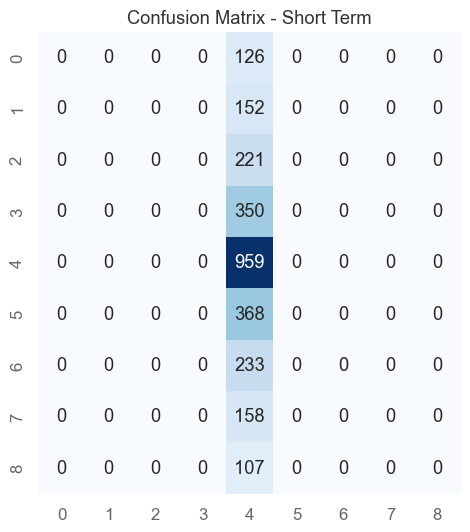

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get all predictions and true labels
y_true_short = []
y_pred_short = []

model_test.eval()
with torch.no_grad():
    for batch in test_loader:
        X_batch, y_short_batch = batch
        X_batch = X_batch.unsqueeze(1)
        X_batch, y_short_batch = X_batch.to(device), y_short_batch.to(device)
        short_term_output = model_test(X_batch)
        _, predicted_short = torch.max(short_term_output.data, 1)
        
        y_true_short.extend(y_short_batch.cpu().numpy())
        y_pred_short.extend(predicted_short.cpu().numpy())

# Convert lists to numpy arrays
y_true_short = np.array(y_true_short)
y_pred_short = np.array(y_pred_short)

# Create confusion matrices
cm_short = confusion_matrix(y_true_short, y_pred_short)

# Plot confusion matrices
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(cm_short, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Short Term')


plt.show()
